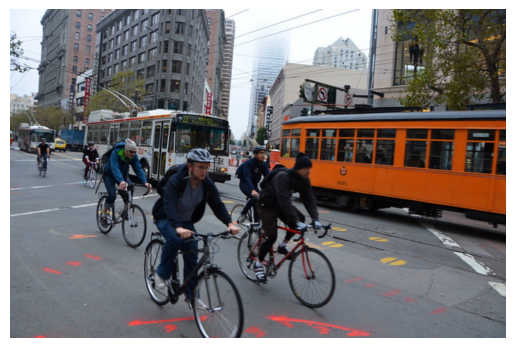

In [ ]:
from PIL import Image
from torchvision import models,transforms
from torchvision.models.segmentation import FCN_ResNet101_Weights
from captum.attr import LayerGradCam,FeatureAblation,LayerActivation,LayerAttribution,visualization as viz
import torch,numpy as np,matplotlib.pyplot as plt
device='mps'
fcn=models.segmentation.fcn_resnet101(weights=FCN_ResNet101_Weights.DEFAULT).to(device).eval()
preprocessing=transforms.Compose([transforms.Resize(640),
                                  transforms.ToTensor()])
normalize=transforms.Normalize(mean=[0.485,0.456,0.406],
                               std=[0.229,0.224,0.225])
def decode_segmap(image,nc=21):  
    label_colors=np.array([(0,0,0),
                           (128,0,0),
                           (0,128,0),
                           (128,128,0),
                           (0,0,128),
                           (128,0,128),
                           (0,128,128),
                           (128,128,128),
                           (64,0,0),
                           (192,0,0),
                           (64,128,0),
                           (192,128,0),
                           (64,0,128),
                           (192,0,128),
                           (64,128,128),
                           (192,128,128),
                           (0,64,0),
                           (128,64,0),
                           (0,192,0),
                           (128,192,0),
                           (0,64,128)])
    r=np.zeros_like(image).astype(np.uint8)
    g=np.zeros_like(image).astype(np.uint8)
    b=np.zeros_like(image).astype(np.uint8)
    for l in range(0,nc):
        idx=image==l
        r[idx]=label_colors[l,0]
        g[idx]=label_colors[l,1]
        b[idx]=label_colors[l,2]
    rgb=np.stack([r,g,b],axis=2)
    return rgb
img=Image.open('8862358875_eecba9fb10_z.jpg')
preproc_img=preprocessing(img)
plt.imshow(preproc_img.permute(1,2,0))
plt.axis('off')
plt.show()

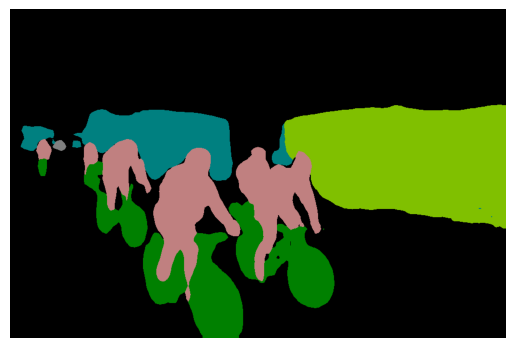

In [2]:
normalized_inp=normalize(preproc_img).unsqueeze(0).to(device)
normalized_inp.requires_grad=True
out=fcn(normalized_inp)['out']
out_max=torch.argmax(out,dim=1,keepdim=True)
rgb=decode_segmap(out_max.detach().cpu().squeeze().numpy())
plt.imshow(rgb)
plt.axis('off')
plt.show()

# Interpreting

In [3]:
def agg_segmentation_wrapper(inp):
    model_out=fcn(inp)['out']
    selected_inds=torch.zeros_like(model_out[0:1]).scatter_(1,out_max,1)
    return (model_out*selected_inds).sum(dim=(2,3))
lgc=LayerGradCam(agg_segmentation_wrapper,fcn.backbone.layer4[2].conv3)
gc_attr=lgc.attribute(normalized_inp,target=6)
la=LayerActivation(agg_segmentation_wrapper,fcn.backbone.layer4[2].conv3)
activation=la.attribute(normalized_inp)
print(f'Input shape: {normalized_inp.shape}\nLayer activation shape: {activation.shape}\nLayer GradCAM shape: {gc_attr.shape}')

Input shape: torch.Size([1, 3, 640, 966])
Layer activation shape: torch.Size([1, 2048, 80, 121])
Layer GradCAM shape: torch.Size([1, 1, 80, 121])


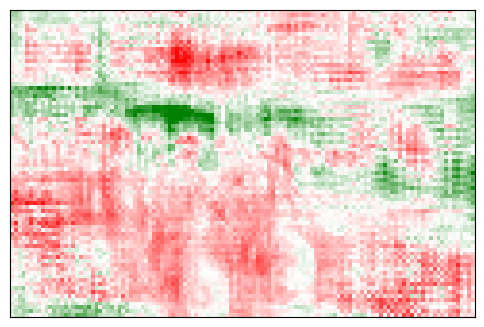

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [4]:
viz.visualize_image_attr(gc_attr[0].cpu().permute(1,2,0).detach().numpy(),sign='all')

In [5]:
upsampled_gc_attr=LayerAttribution.interpolate(gc_attr,normalized_inp.shape[2:])
print(f'Upsampled shape: {upsampled_gc_attr.shape}')

Upsampled shape: torch.Size([1, 1, 640, 966])


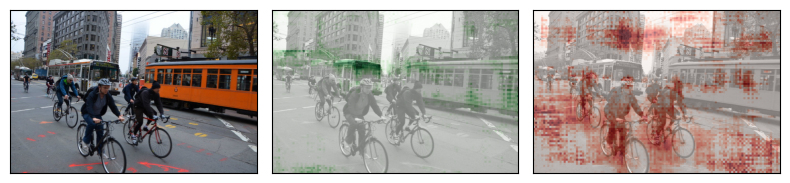

(<Figure size 800x600 with 3 Axes>, [<Axes: >, <Axes: >, <Axes: >])

In [6]:
viz.visualize_image_attr_multiple(upsampled_gc_attr[0].cpu().permute(1,2,0).detach().numpy(),original_image=preproc_img.permute(1,2,0).numpy(),signs=['all','positive','negative'],methods=['original_image','blended_heat_map','blended_heat_map'])

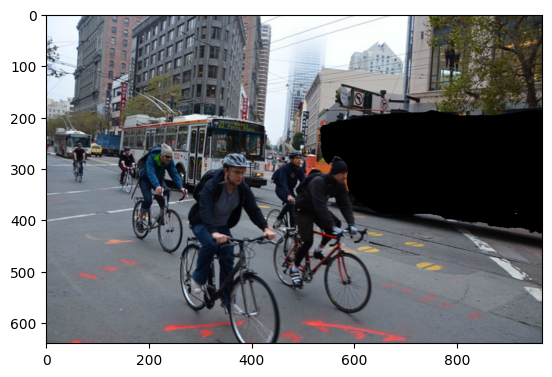

In [7]:
img_without_train=(1-(out_max==19).float())[0].cpu()*preproc_img
plt.imshow(img_without_train.permute(1,2,0))

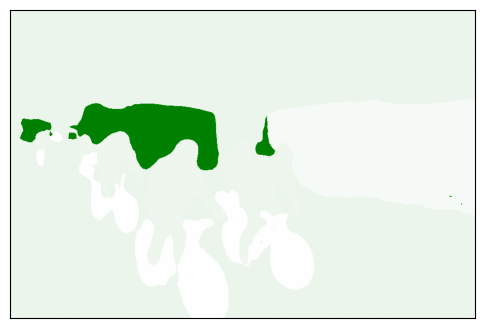

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [8]:
fa=FeatureAblation(agg_segmentation_wrapper)
fa_attr=fa.attribute(normalized_inp,feature_mask=out_max,perturbations_per_eval=2,target=6)
viz.visualize_image_attr(fa_attr[0].cpu().detach().permute(1,2,0).numpy(),sign='all')

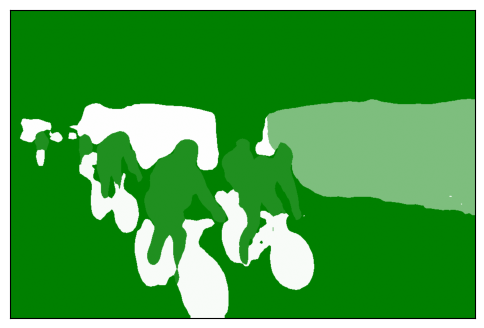

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [9]:
fa_attr_without_max=(1-(out_max==6).float())[0]*fa_attr
viz.visualize_image_attr(fa_attr_without_max[0].cpu().detach().permute(1,2,0).numpy(),sign='all')